   ### Importing packages
   

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import Span, Title, HoverTool, FixedTicker, value, Label, Legend, Div, ColumnDataSource,LinearColorMapper,Jitter, ColorBar, Range1d,LinearAxis
from bokeh.io import export_png, export_svgs
from bokeh.layouts import grid, column
import math
import time
import datetime
from datetime import datetime

### Importing data

In [2]:
#googlemobility = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')
googlemobility = pd.read_csv('./datasets/Global_Mobility_Reports.csv')
#stringency = pd.read_csv('https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv')
stringency = pd.read_csv('./datasets/OxCGRT_latest.csv')

### Filtering data
Removing data from sub-regions and formatting the date columns

In [3]:
#dropping data points for sub-regions within countries
googlemobility = googlemobility[pd.isna(googlemobility['sub_region_1'])]
#converting to datetime format
googlemobility['date'] = [datetime.strptime(str(x), '%m/%d/%Y') for x in googlemobility['date']]
stringency['Date'] = [datetime.strptime(str(x), '%Y%m%d') for x in stringency['Date']]


Filtering data for the chosen European countries and selecting the relevant attributes

In [4]:
#selecting relevant attributes
googlemobility = googlemobility.drop(columns = ['country_region_code', 'iso_3166_2_code', 'sub_region_1', 'sub_region_2', 'census_fips_code', 'metro_area'])
stringency = stringency[['CountryName', 'Date','StringencyIndexForDisplay', 'ConfirmedCases', 'ConfirmedDeaths', 'GovernmentResponseIndexForDisplay']]
#renaming columns
googlemobility = googlemobility.rename(columns={"country_region": "country", 'retail_and_recreation_percent_change_from_baseline':'Retail and Recreation', 'grocery_and_pharmacy_percent_change_from_baseline': 'Grocery and Pharmacy', 'parks_percent_change_from_baseline': 'Parks', 'transit_stations_percent_change_from_baseline': 'Transit', 'workplaces_percent_change_from_baseline':'Workplaces', 'residential_percent_change_from_baseline': 'Residential'})
stringency = stringency.rename(columns = {'CountryName':'country', 'Date':'date', 'StringencyIndexForDisplay': 'stringency_index', 'GovernmentResponseIndexForDisplay':'response_index'})
#selecting countries for analysis
countries = ['Belgium', 'France', 'Germany', 'Italy', 'Netherlands', 'Spain', 'Switzerland', 'United Kingdom']
stringency = stringency[stringency['country'].isin(countries)]
googlemobility = googlemobility[googlemobility['country'].isin(countries)]

Merging the Mobility and Stringency datasets and calculating the Freedom of Association

In [5]:
#merging google and stringency data
final = pd.merge(googlemobility, stringency,  how='inner', on = ['country','date'])
#freedom of association
final['freedom_index'] = (100 - final['stringency_index'])

In [6]:
#lockdown start dates (Switzerland did not impose lockdown, hence an arbitrary date)
start_dates = ['17/03/2020', '16/03/2020', '20/03/2020', '9/03/2020', '23/03/2020', '14/03/2020', '31/12/2050', '23/03/2020']
#colors for plots
colors = ["blue", "orange", "green", "red", "black", "magenta", "purple", "gold"]
#categories of places
#places = ['Retail and Recreation', 'Grocery and Pharmacy', 'Parks', 'Transit', 'Workplaces', 'Residential']
places = ['Workplaces', 'Residential', 'Parks', 'Grocery and Pharmacy']

### Mobility Plots

Creating individual plot for each country 

In [7]:
#separate plot for each country in the list
TOOLS = 'crosshair,save,pan,box_zoom,reset,wheel_zoom'
corr_coeffs = {}
for j, country in enumerate(countries):
    title = country
    p = figure(title=title, title_location="above", y_axis_type="linear",x_axis_type='datetime', tools=TOOLS, toolbar_location=None, plot_width=1000, plot_height=700)
    
    p.yaxis.bounds = (0, 100)
    p.title.text_font_size = '14pt'
    
    #adding second y-axis for Mobility
    p.extra_y_ranges = {"s": Range1d(start=-100, end=300)}
    p.y_range=Range1d(0, 400)
    p.add_layout(LinearAxis(y_range_name="s"), 'right')
    
    #formatting x-axis labels
    p.xaxis.axis_label = 'Date'
    p.xaxis.axis_label_text_font = "calibri"
    p.xaxis.axis_label_text_font_size = "14pt"
    p.xaxis.major_label_orientation = math.pi/2
    
    #drawing lines
    for i, place in enumerate(places):
        data = final[final['country'] == country]
        p.line(x=data.date, y=data[place],  line_color=colors[i], line_width=1, y_range_name="s", legend_label = place)
    p.line(x=data.date, y=data.freedom_index,  line_color=colors[i+1], line_width=3 ,legend_label='Freedom Index')
    
    #adding sundays as ticks on x-axis
    sundays = ['16/02/2020', '23/02/2020', '01/03/2020', '08/03/2020', '15/03/2020', '22/03/2020', '29/03/2020', '05/04/2020', '12/04/2020', '19/04/2020', '26/04/2020', '03/05/2020', '10/05/2020', '17/05/2020', '24/05/2020', '31/05/2020', '07/06/2020', '14/06/2020', '21/06/2020', '28/06/2020', '05/07/2020', '12/07/2020', '19/07/2020', '26/07/2020', '02/08/2020', '09/08/2020', '16/08/2020']
    x = pd.to_datetime(sundays, format = '%d/%m/%Y')
    tick_vals = pd.to_datetime(x).astype(int)/10**6
    p.xaxis.ticker = FixedTicker(ticks=list(tick_vals))
    
    #line indicating start of lockdown
    start_date = time.mktime(pd.to_datetime(start_dates[j],format='%d/%m/%Y').timetuple())*1000
    lockdown_start = Span(location=start_date, dimension='height', line_color='red',line_dash='dashed', line_width=2)
    p.add_layout(lockdown_start)
    
    #label indicating date of lockdown
    date_str = ' Lockdown from ' + pd.to_datetime(start_dates[j],format='%d/%m/%Y').strftime("%d/%m/%Y")
    lockdown_date = Label(x=start_date, y= 275, y_range_name="s", text=date_str, text_color = 'red', text_font_size = '12pt')
    p.add_layout(lockdown_date)
    
    #y-axis labels
    p.add_layout(Title(text='Freedom Index', align="left", text_font = 'cambria',text_font_style = 'italic', text_font_size = '14pt', offset = 10), "left")
    p.add_layout(Title(text='Mobility', align="center",  text_font = 'cambria',text_font_style = 'italic', text_font_size = '14pt'), "right")
    
    #footnotes
    label_opts = dict(x=0, y=0, x_units='screen', y_units='screen')
    caption1 = Label(text='Data Sources:', **label_opts, text_font_size='10pt', text_font_style = 'italic')
    caption2 = Label(text='Oxford COVID-19 Government Response Tracker, Blavatnik School of Government(accessed-10/08/2020)', **label_opts, text_font_size='9pt', text_font_style = 'italic')
    caption3 = Label(text='Google COVID-19 Community Mobility Reports(https://www.google.com/covid19/mobility/, accessed-10/08/2020)', **label_opts, text_font_size='9pt', text_font_style = 'italic')
    p.add_layout(caption1, 'below')
    p.add_layout(caption2, 'below')
    p.add_layout(caption3, 'below')
 
    p.legend.location = "top_left"
    p.legend.background_fill_alpha = 0.4
    p.legend.label_text_font_size = '12pt'
    
    show(p)


### Correlations
Correlation between freedom of association and categories of places for each country

In [8]:
workplaces = final.groupby('country')[['freedom_index', 'Workplaces']].corr().iloc[0::2,-1].reset_index()
residential = final.groupby('country')[['freedom_index', 'Residential']].corr().iloc[0::2,-1].reset_index()
parks = final.groupby('country')[['freedom_index', 'Parks']].corr().iloc[0::2,-1].reset_index()
grocery = final.groupby('country')[['freedom_index', 'Grocery and Pharmacy']].corr().iloc[0::2,-1].reset_index()

In [9]:
from functools import reduce
dfs = [workplaces, residential, parks, grocery]
correlations = reduce(lambda  left,right: pd.merge(left,right,on=['country'],
                                            how='outer'), dfs)
correlations = correlations[['country', 'Residential', 'Parks', 'Grocery and Pharmacy', 'Workplaces']]

In [10]:
print(correlations)

          country  Residential     Parks  Grocery and Pharmacy  Workplaces
0         Belgium    -0.803294  0.183621              0.593222    0.680273
1          France    -0.828341  0.740679              0.741520    0.672989
2         Germany    -0.634878 -0.146166              0.287646    0.558286
3           Italy    -0.829244  0.771445              0.699732    0.767881
4     Netherlands    -0.754381 -0.006639              0.409049    0.502771
5           Spain    -0.773742  0.559085              0.710773    0.801957
6     Switzerland    -0.791557  0.171643              0.327937    0.713404
7  United Kingdom    -0.781892 -0.119291              0.789303    0.820926


In [11]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400 entries, 0 to 1399
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   country                1400 non-null   object        
 1   date                   1400 non-null   datetime64[ns]
 2   Retail and Recreation  1400 non-null   float64       
 3   Grocery and Pharmacy   1399 non-null   float64       
 4   Parks                  1400 non-null   float64       
 5   Transit                1400 non-null   float64       
 6   Workplaces             1400 non-null   float64       
 7   Residential            1400 non-null   float64       
 8   stringency_index       1398 non-null   float64       
 9   ConfirmedCases         1391 non-null   float64       
 10  ConfirmedDeaths        1391 non-null   float64       
 11  response_index         1398 non-null   float64       
 12  freedom_index          1398 non-null   float64       
dtypes: 

### Growth Rate Analysis
This section filters the data by country and calculates the growth rate ratio of confirmed cases. 

In [12]:
#function to filter country data and calculate growth rate ratio
def filter_country_data(country):
    #getting the country-specific rows and combining mobility and stringency data
    data = final[final['country'] == country]
    #data = country_stringency.merge(mobility, left_on=['Date', 'country'], right_on = ['date', 'country'])
    #data['freedom_index'] = (100 - data['GovernmentResponseIndexForDisplay'])
    #calculating daily cases and deaths
    data['daily_cases'] = data['ConfirmedCases'].diff()
    data['daily_deaths'] = data['ConfirmedDeaths'].diff()
    
    #calculating the growth rate ratio
    data['Growth_3'] = data['daily_cases'].rolling(3).sum()/3
    data['Growth_7'] = data['daily_cases'].rolling(7).sum()/7
    data['log_growth_3']=data['Growth_3'].apply(lambda x: 0 if x <=0 else math.log(x))
    data['log_growth_7']=data['Growth_7'].apply(lambda x: 0 if x <=0 else math.log(x))
    data['GR'] = data['log_growth_3']/data['log_growth_7']
    
    #trends for growth rate ratio and daily cases
    data['GR_trend'] = data['GR'].rolling(7).mean()
    data['daily_cases_trend'] = data['daily_cases'].rolling(7).mean()
    
    data = data.loc[(data['date'] > '2020-03-1') & (data['date'] < '2020-04-30')]
    
    return data

In [13]:
#function to calculate the correlation of growth rate ratio with the time lag (in days)
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

Plotting the correlations for each country 

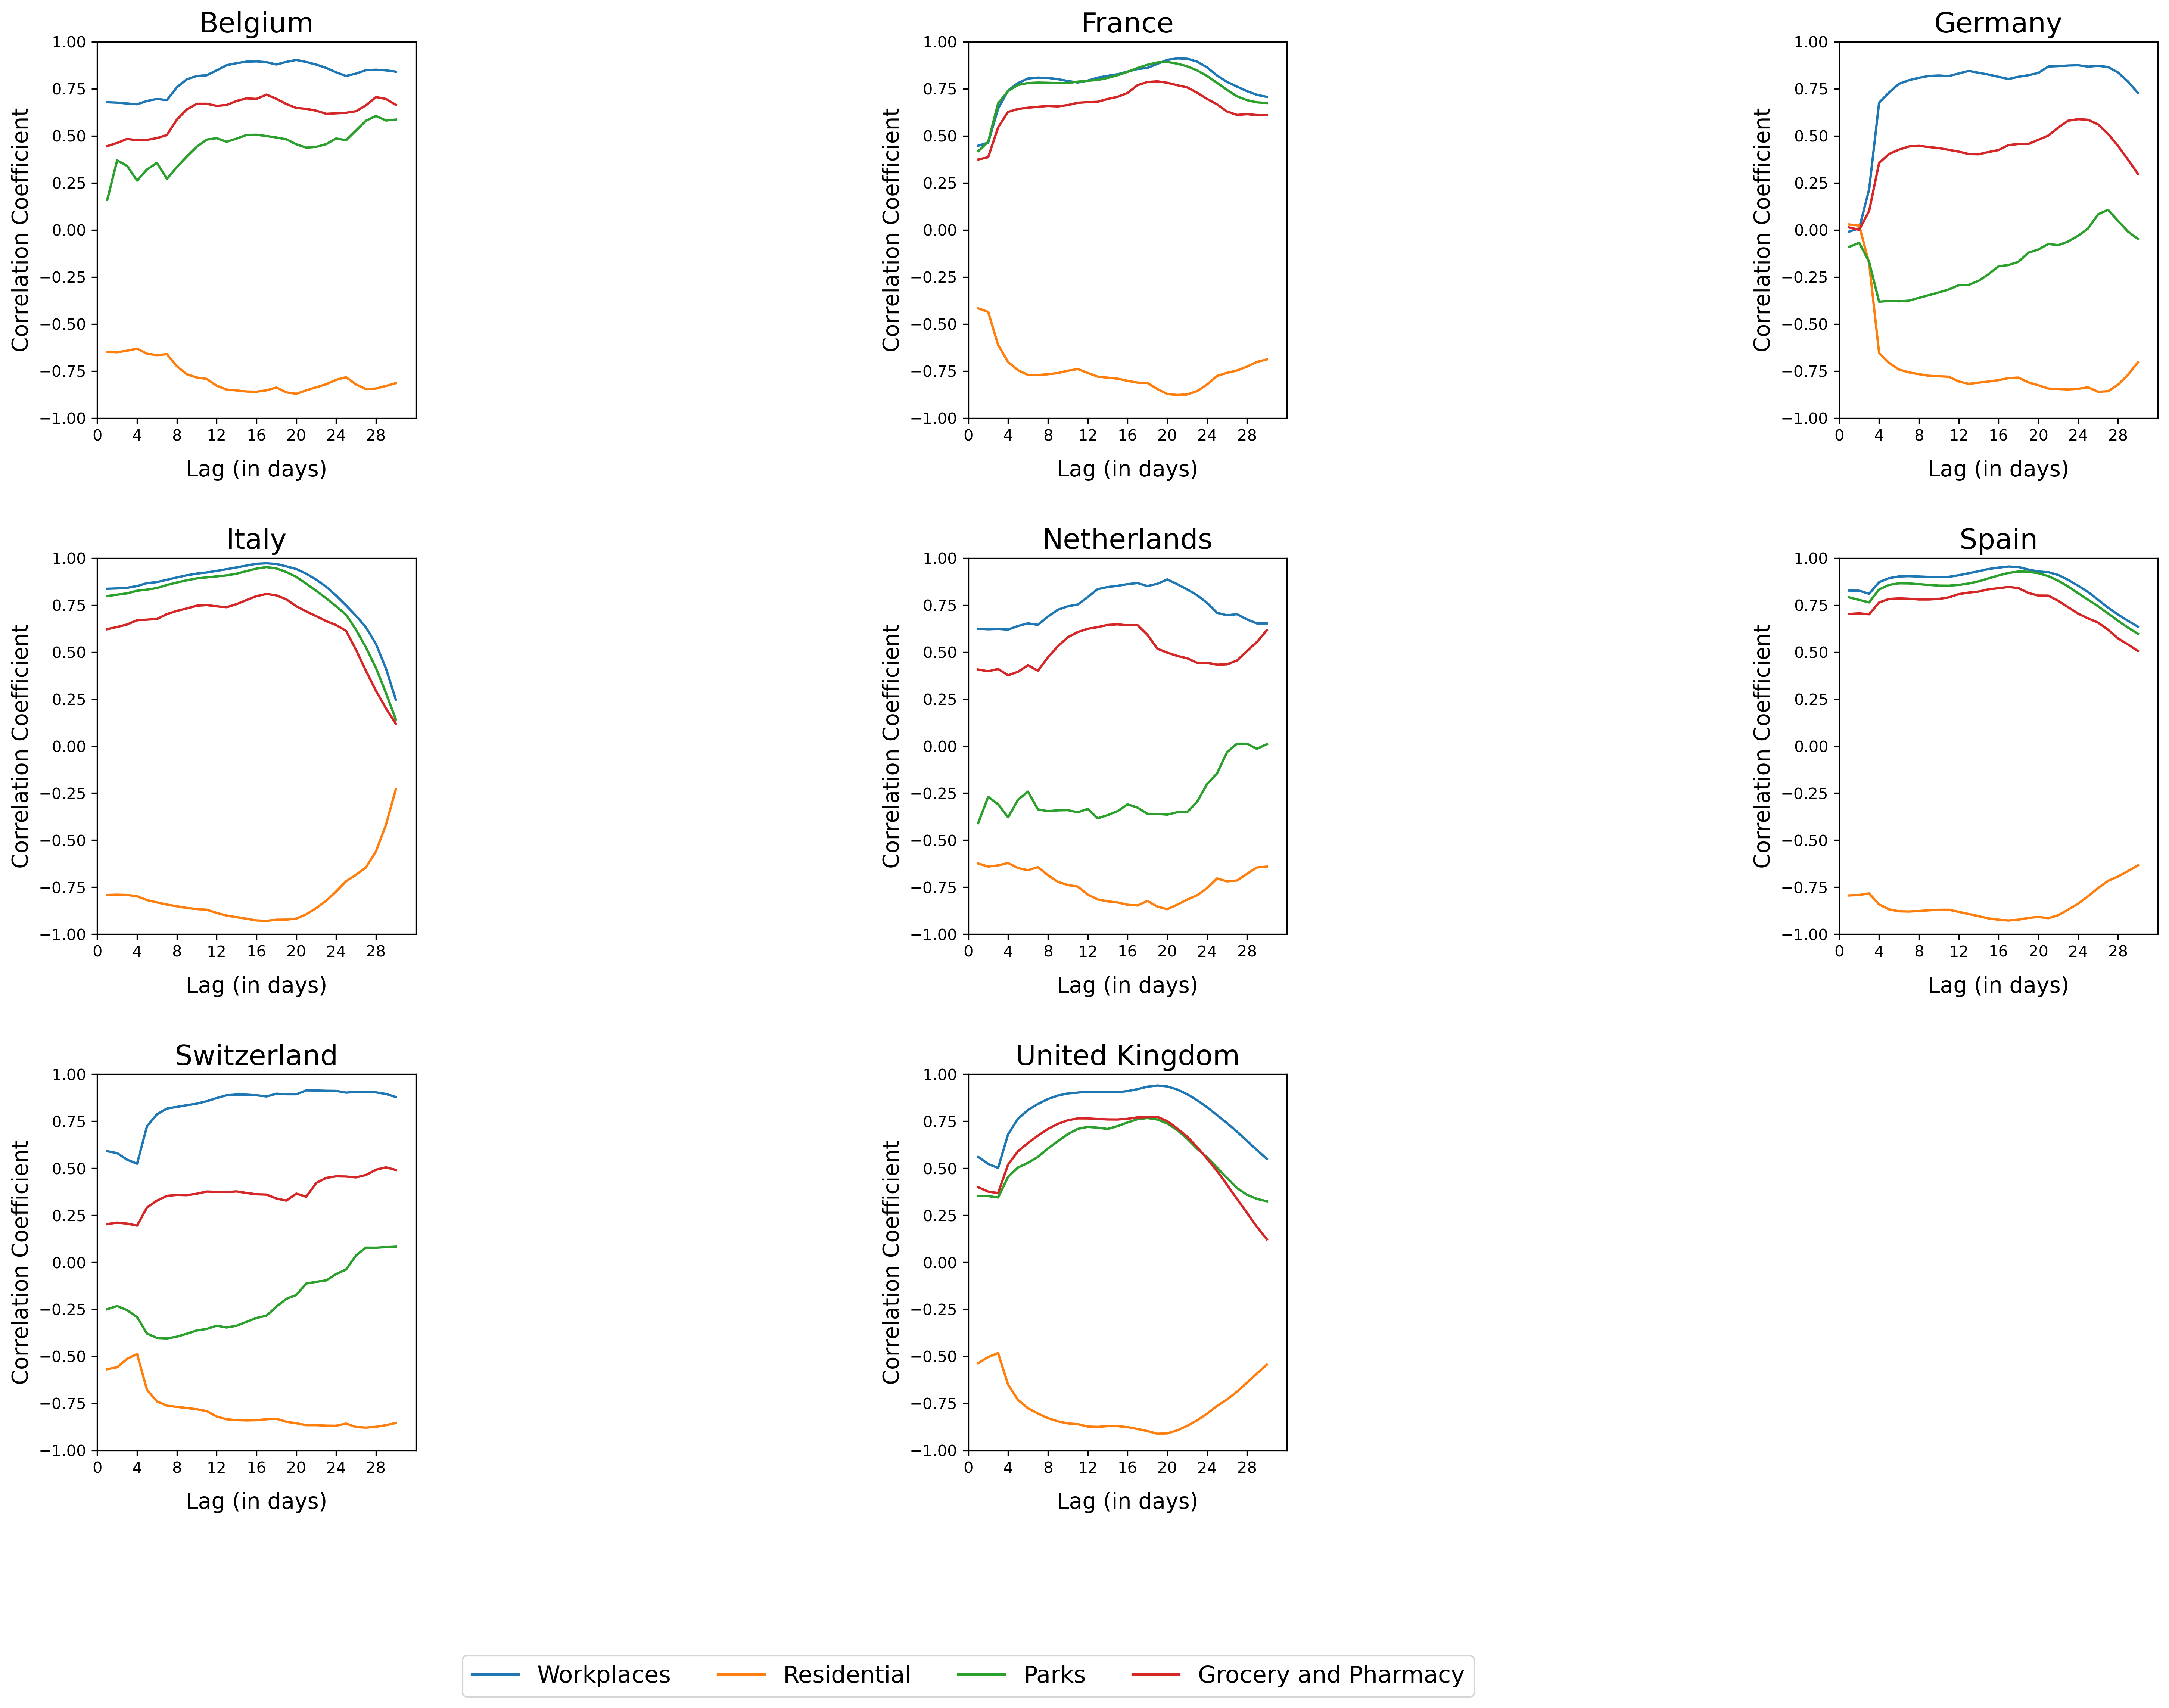

In [14]:
list_corr = []

for i, country in enumerate(countries):
    data = filter_country_data(country)
    corr_df = pd.DataFrame(columns=places)
    
    for place in places:
        xcov_daily = [crosscorr(data['GR_trend'], data[place], lag=i) for i in range(30)]
        corr_df[place] = xcov_daily
    days = list(range(1, 31))
    corr_df['lag'] = days
    corr_df['country']=country
    list_corr.append(corr_df)    
    
df = pd.concat(list_corr)
l = []
fig = plt.figure(figsize=(20,16),constrained_layout=True, dpi=300)
for c,num in zip(countries, range(1,9)):
    df0=df[df['country']==c]
    ax = fig.add_subplot(3,3,num)
    ax.set_xlim([0,32])
    ax.set_ylim([-1,1])
    plt.xticks(np.arange(0, 32, step=4))
    df0.plot(x="lag",y =places, title=c, ax=ax, legend = False)
    ax.set_title(c, fontsize=18)
    ax.set_xlabel("Lag (in days)", fontsize=14, labelpad=10)
    ax.set_ylabel("Correlation Coefficient", fontsize=14)
ax.legend(loc='center',prop={'size': 15},  bbox_to_anchor=(0, -0.6), ncol=4) 

plt.tight_layout(pad=3.0)
plt.show()